# Depth Estimation with MiDaS (DPT_Large)

This notebook estimates depth from a single RGB image using the MiDaS model (DPT_Large) from Intel ISL.

---

### Install Dependencies

In [ ]:
# %pip install torch torchvision timm opencv-python

### Import Libraries

In [5]:
import cv2
import torch
import urllib.request
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt

### Load MiDaS Model

This line loads the pre-trained **DPT_Large** model from the MiDaS repository using `torch.hub`.  
- Use `"DPT_Large"` for high-quality depth estimation.  
- Use `"MiDaS_small"` for faster but less accurate results.  
The model is set to **evaluation mode** using `midas.eval()` to disable training behavior like dropout.

In [3]:
# Load MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.eval()

Using cache found in /home/umerghafoor/.cache/torch/hub/intel-isl_MiDaS_master
/mnt/1C00FF7F00FF5DE8/Users/Code/bidBotBackend/.conda/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
    

### Move model to GPU if available

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
    

### Load and Preprocess Image

- Loads the input image using OpenCV (`cv2.imread`).
- Converts the image from BGR (OpenCV default) to RGB format (required by the model).
- Loads the MiDaS-specific `dpt_transform` to:
  - Resize the image,
  - Normalize pixel values,
  - Convert it into a PyTorch tensor.
- Moves the preprocessed image to the selected device (CPU or GPU).


In [11]:
# Load and preprocess image
img = cv2.imread("your_image.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

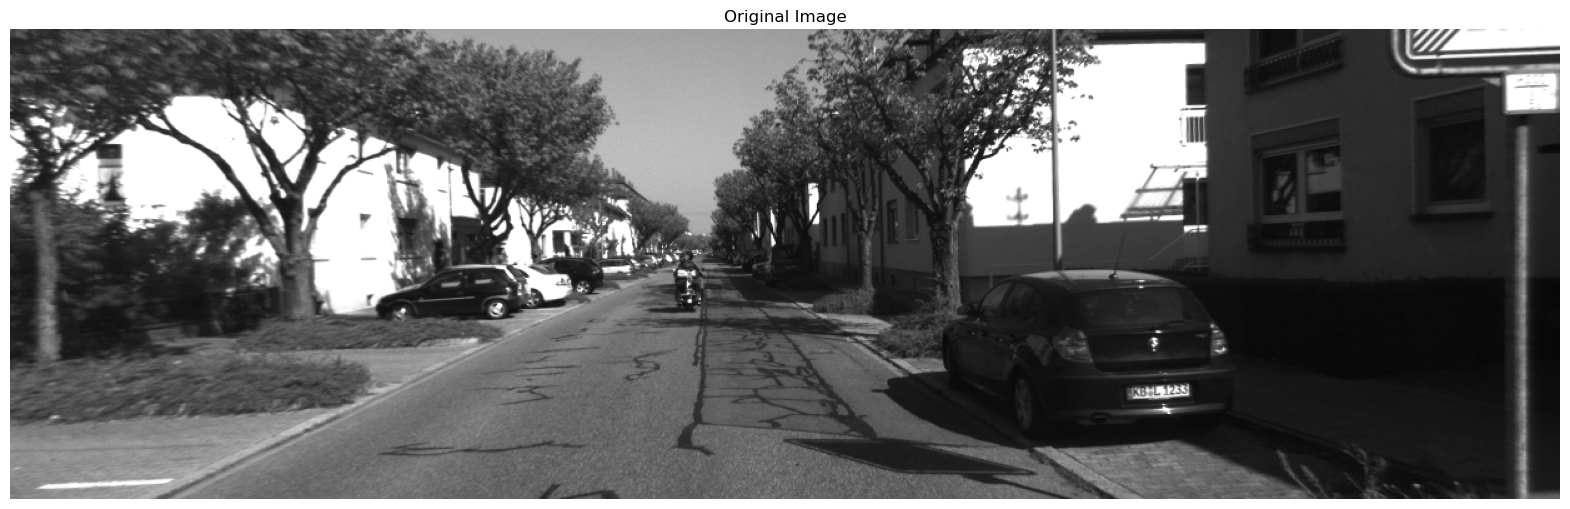

In [12]:
# Show original image
plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [13]:
transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform
input_batch = transform(img).to(device)

Using cache found in /home/umerghafoor/.cache/torch/hub/intel-isl_MiDaS_master


### Predict Depth

- Disables gradient computation with `torch.no_grad()` to save memory and improve speed.
- Runs the image through the MiDaS model to get a raw depth prediction.
- Resizes the output depth map to match the original image size using `interpolate()` with bicubic mode.
- `unsqueeze(1)` adds a channel dimension for interpolation, and `squeeze()` removes it after resizing.


In [16]:
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

### Convert and Normalize Depth Map

- Moves the depth prediction from GPU to CPU and converts it to a NumPy array.
- Normalizes the depth values to the range [0, 255] using OpenCV’s `cv2.normalize()` for visualization.
- Converts the normalized depth map to 8-bit unsigned integers (`uint8`) so it can be saved or displayed as a grayscale image.

In [17]:
depth_map = prediction.cpu().numpy()
depth_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
depth_normalized = depth_normalized.astype(np.uint8)

### Save and show

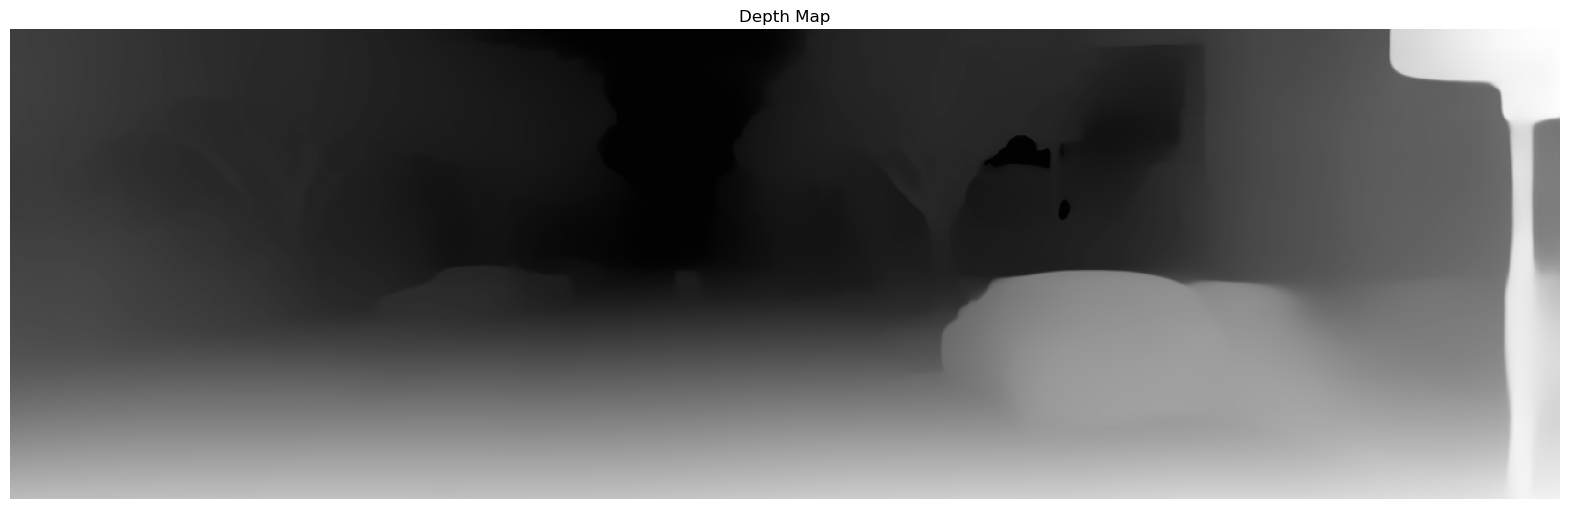

In [18]:
from matplotlib import pyplot as plt


cv2.imwrite("depth_map.jpg", depth_normalized)
plt.figure(figsize=(20, 16))
plt.imshow(depth_normalized, cmap='gray')
plt.title("Depth Map")
plt.axis('off')
plt.show()